In [ ]:
!pip install sentence-transformers numpy scikit-learn umap-learn matplotlib

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Any
import json

# ----------------------------
# Sample sensory profiles
# ----------------------------
SAMPLE_REALMS: Dict[str, Dict[str, str]] = {
    "Moss Merry Way": {
        "taste": "sweet rain, mint, forest honey",
        "feel": "spongy moss, gentle drizzle",
        "color": "emerald, misty teal",
        "sound": "rustling leaves, flute tones",
        "smell": "wet earth, pine sap"
    },
    "Jingle Hooves": {
        "taste": "vanilla snow, peppermint",
        "feel": "crisp winter air, velvet mittens",
        "color": "frost white, crimson",
        "sound": "sleigh bells, laughter",
        "smell": "cinnamon, cold metal"
    },
    "Dusk Hallows": {
        "taste": "smoked berries, ink",
        "feel": "velvet drapes, electric tension",
        "color": "violet, black ink",
        "sound": "whispered lullabies, thunder hum",
        "smell": "candles, wet stone"
    },
    "Pearl Mist": {
        "taste": "salted caramel foam, citrus spray",
        "feel": "cool lagoon ripple, glassy stillness",
        "color": "opal, pale gold flecks",
        "sound": "harp glissando, distant gulls",
        "smell": "sea lavender, sun-warmed shells"
    },
    "Raspberry Ranch": {
        "taste": "ripe raspberry jam, shortbread",
        "feel": "sun-warmed straw, twine",
        "color": "rose, coral red",
        "sound": "bee hum, wooden wind chimes",
        "smell": "berry bramble, fresh cream"
    }
}

# ----------------------------
# Helper functions
# ----------------------------
def profile_to_text(profile: Dict[str, str]) -> str:
    parts = []
    for key in ("taste", "feel", "color", "sound", "smell"):
        if key in profile and profile[key]:
            parts.append(f"{key}: {profile[key]}")
    return " | ".join(parts)

def cosine_sim_matrix(A, B):
    import numpy as np
    A_norm = A / (np.linalg.norm(A, axis=1, keepdims=True) + 1e-10)
    B_norm = B / (np.linalg.norm(B, axis=1, keepdims=True) + 1e-10)
    return A_norm @ B_norm.T

def _split_list(s: str) -> List[str]:
    return [t.strip() for t in s.split(",") if t.strip()]

# ----------------------------
# GSEngine Class
# ----------------------------
@dataclass
class GSEngine:
    realms: Dict[str, Dict[str, str]]
    model_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    _model: Any = field(default=None, init=False, repr=False)
    _names: List[str] = field(default_factory=list, init=False)
    _docs: List[str] = field(default_factory=list, init=False)
    _X: Any = field(default=None, init=False, repr=False)

    def __post_init__(self):
        self._names = list(self.realms.keys())
        self._docs = [profile_to_text(self.realms[name]) for name in self._names]

    def _ensure_model(self):
        if self._model is None:
            from sentence_transformers import SentenceTransformer
            self._model = SentenceTransformer(self.model_name)

    def fit_embeddings(self) -> "GSEngine":
        self._ensure_model()
        self._X = self._model.encode(self._docs, convert_to_numpy=True, normalize_embeddings=False)
        return self

    def search(self, query: str, top_k: int = 5) -> List[Tuple[str, float]]:
        if self._X is None:
            raise RuntimeError("Embeddings not fit. Call .fit_embeddings() first.")
        self._ensure_model()
        import numpy as np
        q = self._model.encode([query], convert_to_numpy=True, normalize_embeddings=False)
        S = cosine_sim_matrix(q, self._X)[0]
        idxs = S.argsort()[::-1][:top_k]
        return [(self._names[i], float(S[i])) for i in idxs]

    def plot_vibe_map(self, annotate: bool = True):
        if self._X is None:
            raise RuntimeError("Embeddings not fit. Call .fit_embeddings() first.")
        import umap, matplotlib.pyplot as plt
        coords = umap.UMAP(n_neighbors=8, min_dist=0.25, random_state=42).fit_transform(self._X)
        xs, ys = coords[:, 0], coords[:, 1]
        plt.figure()
        plt.scatter(xs, ys)
        if annotate:
            for name, x, y in zip(self._names, xs, ys):
                plt.annotate(name, (x, y), xytext=(5, 3), textcoords="offset points")
        plt.title("Glowlock Sensory Engine — Vibe Map (UMAP)")
        plt.show()

    def build_prompt_from_profile(self, name: str, profile: Dict[str, str]) -> str:
        taste = ", ".join(_split_list(profile.get("taste", "")))
        feel = ", ".join(_split_list(profile.get("feel", "")))
        color = ", ".join(_split_list(profile.get("color", "")))
        sound = ", ".join(_split_list(profile.get("sound", "")))
        smell = ", ".join(_split_list(profile.get("smell", "")))
        return (
            f"{name} — storybook cinematic, 2D animation\n"
            f"palette: {color} | atmosphere: {feel} | sounds: {sound}\n"
            f"taste/scent: {taste}, {smell}\n"
            f"Glowlock Labs aesthetic, whimsical, cozy, magical realism"
        )

    def generate_prompt(self, query: str, top_k: int = 1) -> List[Tuple[str, float, str]]:
        hits = self.search(query, top_k=top_k)
        results = []
        for name, score in hits:
            p = self.build_prompt_from_profile(name, self.realms[name])
            results.append((name, score, p))
        return results


In [ ]:
gse = GSEngine(SAMPLE_REALMS)
gse.fit_embeddings()

results = gse.search("dreamy forest rain with honey and flute sounds")
print(results)


In [14]:
prompts = gse.generate_prompt("dreamy forest rain with honey and flute sounds", top_k=2)
for name, score, prompt in prompts:
    print(f"\n{name} ({score:.3f})")
    print(prompt)



Moss Merry Way (0.566)
Moss Merry Way — storybook cinematic, 2D animation
palette: emerald, misty teal | atmosphere: spongy moss, gentle drizzle | sounds: rustling leaves, flute tones
taste/scent: sweet rain, mint, forest honey, wet earth, pine sap
Glowlock Labs aesthetic, whimsical, cozy, magical realism

Dusk Hallows (0.373)
Dusk Hallows — storybook cinematic, 2D animation
palette: violet, black ink | atmosphere: velvet drapes, electric tension | sounds: whispered lullabies, thunder hum
taste/scent: smoked berries, ink, candles, wet stone
Glowlock Labs aesthetic, whimsical, cozy, magical realism


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


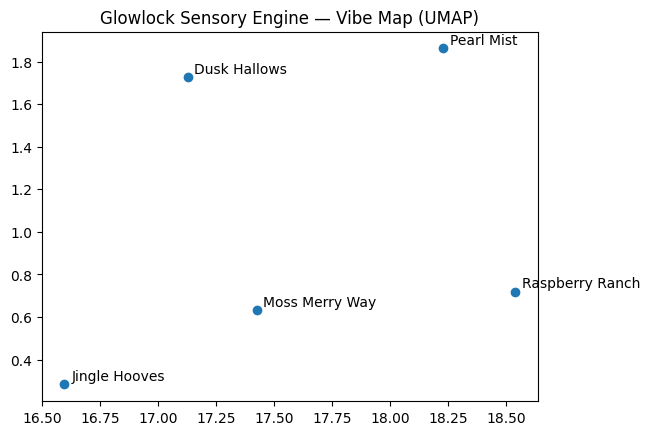

In [16]:
gse.plot_vibe_map()

In [17]:
!pip install streamlit

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 34.9 MB/s  0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.2/731.2 kB 18.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.2/31.2 MB 34.7 MB/s  0:00:00m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11/11 [streamlit]11 [streamlit]


In [ ]:
!jupyter nbconvert --to script Glowlock_Sensory_Engine.ipynb


In [ ]:
!ls


In [ ]:
%%writefile app.py
import sys, os
# make sure we can import your converted module from the current folder
sys.path.append(os.getcwd())

import streamlit as st
from Glowlock_Sensory_Engine import GSEngine, SAMPLE_REALMS

st.set_page_config(page_title="Glowlock Sensory Engine", page_icon="🌲", layout="wide")
st.title("🌲 Glowlock Sensory Engine")
st.caption("Narrative worldbuilding meets machine learning · Glowlock Labs © 2025")

@st.cache_resource
def load_engine():
    gse = GSEngine(SAMPLE_REALMS)
    gse.fit_embeddings()
    return gse

gse = load_engine()

# — Sidebar —
st.sidebar.header("🔍 Vibe Search")
query = st.sidebar.text_input(
    "Describe a feeling, scene, or vibe:",
    "dreamy forest rain with honey and flute sounds"
)
top_k = st.sidebar.slider("Number of results", 1, 5, 3)
show_map = st.sidebar.checkbox("Show 2D vibe map")

# — Main —
if st.sidebar.button("Search"):
    results = gse.generate_prompt(query, top_k=top_k)
    for name, score, prompt in results:
        st.subheader(f"{name} · similarity {score:.3f}")
        st.code(prompt, language="markdown")

if show_map:
    import matplotlib.pyplot as plt
    coords = gse.umap_2d()
    xs, ys = coords[:, 0], coords[:, 1]
    fig, ax = plt.subplots()
    ax.scatter(xs, ys)
    for name, x, y in zip(gse._names, xs, ys):
        ax.text(x, y, name, fontsize=9, ha="center")
    ax.set_title("Glowlock Realm Vibe Map (UMAP)")
    st.pyplot(fig)


In [ ]:
!streamlit run app.py

In [ ]:
from __future__ import annotations
from dataclasses import dataclass, field
from typing import Dict, List, Tuple, Any
import json

# ----------------------------
# Sample sensory profiles
# ----------------------------
SAMPLE_REALMS: Dict[str, Dict[str, str]] = {
    "Moss Merry Way": {
        "taste": "sweet rain, mint, forest honey",
        "feel": "spongy moss, gentle drizzle",
        "color": "emerald, misty teal",
        "sound": "rustling leaves, flute tones",
        "smell": "wet earth, pine sap"
    },
    "Jingle Hooves": {
        "taste": "vanilla snow, peppermint",
        "feel": "crisp winter air, velvet mittens",
        "color": "frost white, crimson",
        "sound": "sleigh bells, laughter",
        "smell": "cinnamon, cold metal"
    },
    "Dusk Hallows": {
        "taste": "smoked berries, ink",
        "feel": "velvet drapes, electric tension",
        "color": "violet, black ink",
        "sound": "whispered lullabies, thunder hum",
        "smell": "candles, wet stone"
    },
    "Pearl Mist": {
        "taste": "salted caramel foam, citrus spray",
        "feel": "cool lagoon ripple, glassy stillness",
        "color": "opal, pale gold flecks",
        "sound": "harp glissando, distant gulls",
        "smell": "sea lavender, sun-warmed shells"
    },
    "Raspberry Ranch": {
        "taste": "ripe raspberry jam, shortbread",
        "feel": "sun-warmed straw, twine",
        "color": "rose, coral red",
        "sound": "bee hum, wooden wind chimes",
        "smell": "berry bramble, fresh cream"
    }
}

# ----------------------------
# Helpers
# ----------------------------
def profile_to_text(profile: Dict[str, str]) -> str:
    parts = []
    for key in ("taste", "feel", "color", "sound", "smell"):
        if key in profile and profile[key]:
            parts.append(f"{key}: {profile[key]}")
    return " | ".join(parts)

def cosine_sim_matrix(A, B):
    import numpy as np
    A_norm = A / (np.linalg.norm(A, axis=1, keepdims=True) + 1e-10)
    B_norm = B / (np.linalg.norm(B, axis=1, keepdims=True) + 1e-10)
    return A_norm @ B_norm.T

def _split_list(s: str) -> List[str]:
    return [t.strip() for t in s.split(",") if t.strip()]

# ----------------------------
# Core Engine
# ----------------------------
@dataclass
class GSEngine:
    realms: Dict[str, Dict[str, str]]
    model_name: str = "sentence-transformers/all-MiniLM-L6-v2"
    _model: Any = field(default=None, init=False, repr=False)
    _names: List[str] = field(default_factory=list, init=False)
    _docs: List[str] = field(default_factory=list, init=False)
    _X: Any = field(default=None, init=False, repr=False)

    def __post_init__(self):
        self._names = list(self.realms.keys())
        self._docs = [profile_to_text(self.realms[name]) for name in self._names]

    # Embeddings
    def _ensure_model(self):
        if self._model is None:
            from sentence_transformers import SentenceTransformer
            self._model = SentenceTransformer(self.model_name)

    def fit_embeddings(self) -> "GSEngine":
        self._ensure_model()
        self._X = self._model.encode(self._docs, convert_to_numpy=True, normalize_embeddings=False)
        return self

    # Search
    def search(self, query: str, top_k: int = 5) -> List[Tuple[str, float]]:
        if self._X is None:
            raise RuntimeError("Embeddings not fit. Call .fit_embeddings() first.")
